### Here we will try to reconstruct the supernova rate as a function of time

Note that whenever we need a 'benchmark' normalisation for the SN rate, we now use 3e-2/yr.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import swordfish as sf
from random import *
from tqdm import tqdm
import scipy.interpolate as interpolate
from scipy.optimize import minimize
from scipy.integrate import quad
import paleopy as paleopy
from WIMpy import DMUtils as DMU
from scipy.special import gamma

import os

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=16)

In [4]:
import h5py

In [5]:
# Fermi-Dirac spectrum
def dNdE(E, Etot, T, alpha):
    # E is the list of energies [keV]
    # T is the neutrino temperature [keV]
    # Etot is the total energy emitted in the CC supernova [kev]
    # dNdE in keV^-1
#     dom = np.exp(E/T) + 1
#     return Etot*120.*(E**2.)/7./(np.pi**4.)/(T**4.)/dom
    numer = Etot*((1+alpha)**(1+alpha))*(E**alpha)*np.exp(-(1+alpha)*E/T)
    return numer/gamma(1+alpha)/(T**(2+alpha))

In [6]:
def inverse_transform_sampling(function, x_range, nbins=100, n_samples=1000):
    bins = np.linspace(x_range[0], x_range[-1], num=nbins)
    pdf = function(np.delete(bins,-1) + np.diff(bins)/2)
    Norm = np.sum(pdf*np.diff(bins))
    pdf /= Norm
    cum_values = np.zeros(bins.shape)
    cum_values[1:] = np.cumsum(pdf*np.diff(bins))
    inv_cdf = interpolate.interp1d(cum_values, bins)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

In [7]:
R_E = 8.12 # kpc - Table A1 in 1807.09409 

def calc_f():
    R_gal = 50
    N_SN = int(1e5)
    
    def calc_dist(x, y, z):
        x_E = R_E
        y_E = 0.0
        z_E = 0.0
        return np.sqrt((x-x_E)**2+(y-y_E)**2+(z-z_E)**2)
    
    phi = np.random.uniform(0,2*np.pi, size=N_SN)
    z = np.random.exponential(scale=0.33, size=N_SN)
    
    # https://arxiv.org/abs/1612.07781
    l_c = 2.5 #kpc
    r_B = 2.0 #kpc
    sigma_0 = 611e6 #Msun/kpc^2

    def sigma_disc(r):
        #return r*sigma_0*l_c*((r-r_B)**2 + l_c**2)**-0.5
        r_d = 2.9 #kpc
        return r*np.exp(-r/r_d)

    x_temp = np.linspace(0,R_gal,num=100)
    r = inverse_transform_sampling(sigma_disc, x_temp, nbins=100, n_samples=N_SN)
    
    theta = np.pi/2.
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    
    for i in tqdm(range(N_SN)):
        R = calc_dist(x, y, z)
        
    b_edge = np.linspace(0,R_gal,100)
    b_c = b_edge[:-1] + np.diff(b_edge)/2
    dist_bin = np.histogram(R, bins=b_edge, normed=True)
    
    f = interpolate.interp1d(b_c, dist_bin[0], bounds_error=False, fill_value=(0.0,0.0))
    return f

100%|██████████| 100000/100000 [00:48<00:00, 2063.65it/s]
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


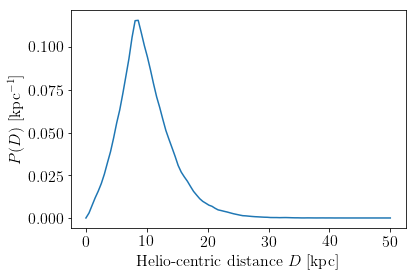

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [8]:
def galactic_SN(E):
    T_v = np.array([13.3e3,14.6e3,15.0e3,15.0e3,15.0e3,15.0e3]) # keV
    Etot = np.array([6.0e52,4.3e52,2.0e52,2.0e52,2.0e52,2.0e52]) # ergs
    alpha = np.array([3., 3.3, 3., 3., 3., 3.])
#     T_v = np.array([13.3e3,13.3e3,13.3e3,13.3e3,13.3e3,13.3e3])
#     Etot = np.array([6.0e52,6.0e52,6.0e52,6.0e52,6.0e52,6.0e52])
    Etot *= 6.242e+8 # ergs to keV
    F = calc_f()
    
    xlist = np.linspace(0, 50, 100)
    plt.figure()
    plt.plot(xlist, F(xlist))
    plt.xlabel(r"Helio-centric distance $D$ [kpc]")
    plt.ylabel(r"$P(D)$ [kpc$^{-1}$]")
    plt.show()
    
    dist_weight = lambda R: F(R)/4/np.pi/((R)**2.) 
    dndE = np.zeros_like(E)
    for i in range(6):
        dndE += dNdE(E, Etot[i], T_v[i], alpha[i])
    dNdE_gal = dndE*quad(dist_weight, 0., 30)[0]/(3.086e+21**2) # Convert kpc^-2 to cm^-2
    # returns in s^-1 keV^-1 cm^-2 - assuming one CC SN per second
    return dNdE_gal
    

Elist = np.logspace(-1,6,1000) # keV
dndE = galactic_SN(Elist)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


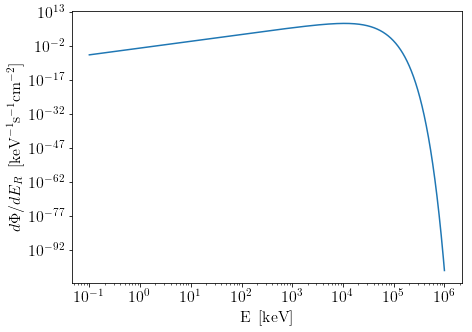

In [9]:
plt.figure(figsize=(7,5))
plt.loglog(Elist,dndE)
plt.ylabel(r"$d\Phi/dE_R~\, [\mathrm{keV}^{-1}\mathrm{s}^{-1}\mathrm{cm}^{-2}]$")
plt.xlabel(r"$\mathrm{E}~\, [\mathrm{keV}]$")
# plt.ylim(0.0001,4.)
plt.show()

### Lets transform this into a recoil spectra

In [10]:
dndE_gal = interpolate.interp1d(Elist*1e-3, dndE*1e3, bounds_error=False, fill_value=(0.0,0.0)) # converting keV --> MeV

In [11]:
Epso = paleopy.Mineral("Epsomite")
dRdE = np.zeros_like(dndE)

x = 0
for nuc in Epso.nuclei:
    dRdE += Epso.ratio_nuclei[nuc]*(np.vectorize(DMU.dRdE_CEvNS)(Elist, Epso.N_p[x], Epso.N_n[x],
                                                                 flux_name="user", flux_func = dndE_gal))
    x += 1
    
# returns values in keV^-1 kg^-1 day^-1

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


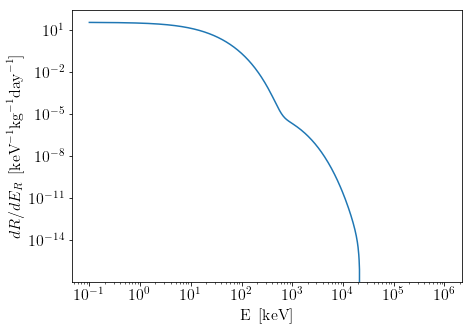

In [12]:
plt.figure(figsize=(7,5))
plt.loglog(Elist,dRdE)
plt.ylabel(r"$dR/dE_R~\, [\mathrm{keV}^{-1}\mathrm{kg}^{-1}\mathrm{day}^{-1}]$")
plt.xlabel(r"$\mathrm{E}~\, [\mathrm{keV}]$")
# plt.savefig("../plots/recoil_rate_galactic.pdf", bbox_inches="tight")
plt.show()

### Now lets calculate the track length spectra

Mineral name: Epsomite
    N_nuclei: 4
    Molar mass: 246.3  g/mol
    nucleus 	*	 abun.  *	 (N_p, N_n)
 **************************************************
    Mg		*	0.09866017052375152	*	(12.0, 12.3)
    S		*	0.12992285830288267	*	(16.0, 16.0)
    O		*	0.7145757206658546	*	(8.0, 8.0)
    H		*	0.05684125050751116	*	(1.0, 0.0)
Plotting SRIM data for Epsomite:


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


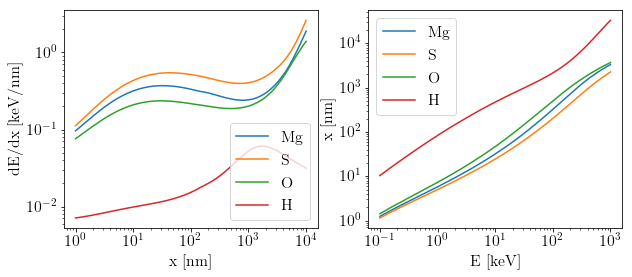

In [13]:
Epso.showProperties()
Epso.showSRIM()

In [14]:
x0 = 15.0/2.0
x = np.logspace(0,3,num=200)

dRdx_temp = np.zeros_like(x)
for i, nuc in enumerate(Epso.nuclei):
    if (nuc != "H"):
        xtemp = Epso.Etox_nuclei[nuc](Elist)
        dRdx_nuc = (np.vectorize(DMU.dRdE_CEvNS)(Elist, Epso.N_p[i], Epso.N_n[i], flux_name="user", flux_func = dndE_gal)
                                            *Epso.dEdx_nuclei[nuc](xtemp))
        temp_interp = interpolate.interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
        dRdx_temp += Epso.ratio_nuclei[nuc]*temp_interp(x)
    
dRdx = dRdx_temp*1e6*365+1e-20 # kg/Myr/nm
dRdx_interp = interpolate.interp1d(x, dRdx, fill_value='extrapolate')

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


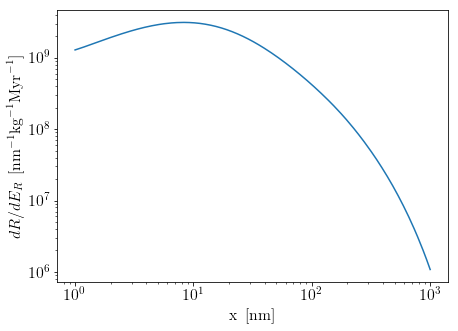

In [15]:
plt.figure(figsize=(7,5))
plt.loglog(x,dRdx)
plt.ylabel(r"$dR/dE_R~\, [\mathrm{nm}^{-1}\mathrm{kg}^{-1}\mathrm{Myr}^{-1}]$")
plt.xlabel(r"$\mathrm{x}~\, [\mathrm{nm}]$")
# plt.ylim(0.1,100)
# plt.savefig("../plots/tracklength_spectra_galactic.pdf", bbox_inches="tight")
plt.show()

### Finally, we can estimate the minimum rate required to be detectable

In [16]:
def MakeSF(mineral, sigma, exposure):
    systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-2, 1e-2]
    dRdx_BG = paleopy.GetBackground(mineral, sigma)
    SF = sf.Swordfish(dRdx_BG, T=systematics, E=np.ones_like(dRdx_BG[0])*exposure)
    return SF, dRdx_BG

print("Catching some Swordfish with Epsomite...")
SF_Epso_15nm, Epso_bkg = MakeSF(Epso, 15.0, 100.)
print("...done.")

Catching some Swordfish with Epsomite...
 DMutils.py: Loading neutrino flux for the first time...
Loading neutrino fluxes for...
    DSNB
    atm
    hep
    8B
    15O
    17F
    pep
    13N
    pp
    7Be-384
    7Be-861
...done.


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


...done.


In [28]:
from scipy.special import erf
def window(x, x_a, x_b, sigma):
    return 0.5*(erf((x - x_a)/(np.sqrt(2.0)*sigma)) - erf((x - x_b)/(np.sqrt(2.0)*sigma)))

sigma = 15.
x = np.logspace(np.log10(x0), 3, 70)
#x = np.linspace(x0, 1000, 70)

x_c = x[:-1] + np.diff(x)/2
dRdx_binned = np.zeros_like(x_c)

for i in tqdm(range(x_c.size)):
    x1 = x_c[i] - 5.0*sigma
    x2 = x_c[i] + 5.0*sigma
    x1 = np.clip(x1, 0.1, 1e5)
    intge = lambda y: dRdx_interp(y)*window(y, x[i], x[i+1], sigma)
    dRdx_binned[i] = quad(intge, x1, x2)[0] + 1e-30

  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
  1%|▏         | 1/69 [00:00<00:07,  9.03it/s]/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
100%|██████████| 69/69 [00:05<00:00, 11.69it/s]


In [29]:
R0 = SF_Epso_15nm.discoveryreach(dRdx_binned, 2.87e-7)
print(R0)

1.1188912189559948e-09


### Euclideanized signals

#### Generalising

In [30]:
load_from_file = True

In [31]:
N_Gyr = 365*24*3600*1e9
print("Number of SN that go off in a gigayear (if the rate is 1/s):", N_Gyr)
N0 = R0*N_Gyr
print("5-sigma observable number of supernova (per gigayear):", N0)

Number of SN that go off in a gigayear (if the rate is 1/s): 3.1536e+16
5-sigma observable number of supernova (per gigayear): 35285353.48099625


In [32]:
print(R0)

1.1188912189559948e-09


In [33]:
N_samps = 10
lower_list = np.zeros(N_samps)
upper_list = np.zeros(N_samps)
med_list = np.zeros(N_samps)

exp_list = np.linspace(0.1, 1.0, N_samps)*1e3*0.1
R_bench_Gyr = 3e-2*1e9 #Benchmark rate per Gyr
print(N0)
print(R_bench_Gyr) #This is the rate per Gyr (normalised to 3e-2 SN per year, or roughly one every 33 years)

35285353.48099625
30000000.0


In [34]:
systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-2, 1e-2]
dRdx_BG = paleopy.GetBackground(Epso, sigma=15.0)

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [35]:
#Assuming a constant merger rate of R_Gyr

for i, e in enumerate(exp_list):
    print("Exposure:", e)

    ESfile = "../ES/hdf5/Epso_15nm_exp{:.1f}_C238_0.01.hdf5".format(e)
    
    if (load_from_file and os.path.isfile(ESfile)):
        print("    Loading from file...")
        
    else:
        print("    Calculating from scratch...")
    
        SF_Epso_15nm = sf.Swordfish(dRdx_BG, T=systematics, E=np.ones_like(dRdx_BG[0])*e)
    
        N_SN = np.logspace(np.log10(R_bench_Gyr/100), np.log10(R_bench_Gyr*100), 2500)
    
        ES = []
        N_SN_save = []
    
        for N in tqdm(N_SN, desc="Euclideanizing these bad-boys"):
            ES_temp = SF_Epso_15nm.euclideanizedsignal(dRdx_binned*N/N_Gyr) #Divide through by number of seconds/Gyr and multiply by rate per Gyr
            N_SN_save.append(N)
            ES.append(ES_temp)

        # Output to new hdf5
        hf = h5py.File(ESfile, 'w')
        hf.create_dataset('ES', data=ES)
        hf.create_dataset('N_SN', data=N_SN_save)
        hf.close()
    
    assert os.path.isfile(ESfile), "File not found: " + ESfile

    #Load results from file
    root = h5py.File(ESfile)
    ES = np.array(root['ES'])
    N_SN_0 = np.array(root['N_SN'])
    N_SN = np.zeros([N_SN_0.shape[0],1])
    N_SN[:,0] = N_SN_0
    root.close()
    
    
    #Find errorsbars
    shEps = sf.SignalHandler(N_SN, ES, verbose=True)
    P0 = [R_bench_Gyr]
    pp, el_ind = shEps.query_region(P0, sigma=2.0, d=1, return_indices=True)
    lower = np.min(pp)
    upper = np.max(pp)
    lower_list[i] = lower
    upper_list[i] = upper
    med_list[i] = R_bench_Gyr

Exposure: 10.0
    Loading from file...
Initializing ball trees for nearest neighbour searches...
...done!
Exposure: 20.0
    Loading from file...
Initializing ball trees for nearest neighbour searches...
...done!
Exposure: 30.000000000000007
    Loading from file...
Initializing ball trees for nearest neighbour searches...
...done!
Exposure: 40.0
    Loading from file...
Initializing ball trees for nearest neighbour searches...
...done!
Exposure: 50.0
    Loading from file...
Initializing ball trees for nearest neighbour searches...
...done!
Exposure: 60.0
    Loading from file...
Initializing ball trees for nearest neighbour searches...
...done!
Exposure: 70.00000000000001
    Loading from file...
Initializing ball trees for nearest neighbour searches...
...done!
Exposure: 80.0
    Loading from file...
Initializing ball trees for nearest neighbour searches...
...done!
Exposure: 90.0
    Loading from file...
Initializing ball trees for nearest neighbour searches...
...done!
Exposure: 

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


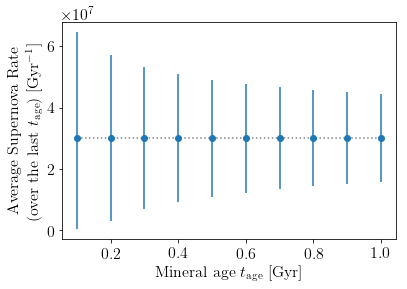

In [36]:
plt.figure()

exp_list_dense = np.linspace(0.1, 1, 1000)

plt.plot(exp_list_dense, R_bench_Gyr + 0.0*exp_list_dense, color='grey', linestyle=':')

plt.errorbar(exp_list/100, med_list, yerr=[med_list-lower_list, upper_list-med_list],fmt='o')

plt.xlabel(r'Mineral age $t_\mathrm{age}$ [Gyr]')
plt.ylabel('Average Supernova Rate\n(over the last $t_\\mathrm{age}$) [Gyr$^{-1}$]')

# plt.savefig("../plots/ReconstructedRate.pdf", bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


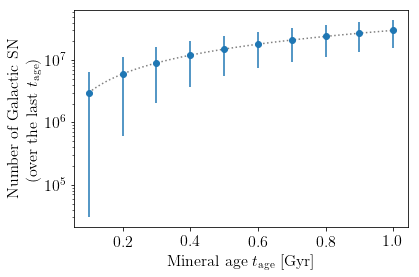

In [37]:
plt.figure()

exp_list_dense = np.linspace(0.1, 1, 1000)

plt.plot(exp_list_dense, R_bench_Gyr*exp_list_dense, color='grey', linestyle=':')
plt.errorbar(exp_list/100, med_list*exp_list/100, yerr=[(med_list-lower_list)*exp_list/100, (upper_list-med_list)*exp_list/100],fmt='o')


plt.xlabel(r'Mineral age $t_\mathrm{age}$ [Gyr]')
plt.ylabel('Number of Galactic SN\n(over the last $t_\\mathrm{age}$)')

plt.gca().set_yscale('log')

# plt.savefig("../plots/ReconstructedN_SN.pdf", bbox_inches='tight')

plt.show()

### Error bars for the average SN rate

In [38]:
#Error bars for an exposure of 1 Gyr and 0.01 ppb

ESfile = "../ES/hdf5/Epso_15nm_exp100.0_C238_0.01.hdf5"

#Load results from file
root = h5py.File(ESfile)
ES = np.array(root['ES'])
N_SN_0 = np.array(root['N_SN'])
N_SN = np.zeros([N_SN_0.shape[0],1])
N_SN[:,0] = N_SN_0
root.close()
    
    
#Find errorsbars
shEps = sf.SignalHandler(N_SN, ES, verbose=True)
P0 = [R_bench_Gyr]
pp, el_ind = shEps.query_region(P0, sigma=1.0, d=1, return_indices=True)
lower = np.min(pp)
upper = np.max(pp)
print("1sigma error in units of 1e-2 SN/yr:", 3 - lower/1e7, upper/1e7 - 3)

#Error bars for an exposure of 1 Gyr and 0.001 ppb

ESfile = "../ES/hdf5/Epso_15nm_exp100.0_C238_0.001.hdf5"

#Load results from file
root = h5py.File(ESfile)
ES = np.array(root['ES'])
N_SN_0 = np.array(root['N_SN'])
N_SN = np.zeros([N_SN_0.shape[0],1])
N_SN[:,0] = N_SN_0
root.close()
    
    
#Find errorsbars
shEps = sf.SignalHandler(N_SN, ES, verbose=True)
P0 = [R_bench_Gyr]
pp, el_ind = shEps.query_region(P0, sigma=1.0, d=1, return_indices=True)
lower = np.min(pp)
upper = np.max(pp)
print("1sigma error in units of 1e-2 SN/yr:",3 - lower/1e7, upper/1e7 - 3)

Initializing ball trees for nearest neighbour searches...
...done!
1sigma error in units of 1e-2 SN/yr: 0.7203217504414461 0.7218486607337549
Initializing ball trees for nearest neighbour searches...
...done!
1sigma error in units of 1e-2 SN/yr: 0.27915195420886807 0.2834993979586309


### Opal Fruits

In [39]:
#Including a star burst at 

#t_star in Gyr
def calcConstraints(R_list, C238=0.01, verbose = False):
    assert (len(R_list) == N_samps)
    
    lower_list = np.zeros(N_samps)
    upper_list = np.zeros(N_samps)
    med_list = np.zeros(N_samps)
    for i, e in enumerate(exp_list):
        if verbose:
            print("Exposure:", e)

        ESfile = "../ES/hdf5/Epso_15nm_exp{:.1f}_C238_{}.hdf5".format(e, C238)
        
        if (load_from_file and os.path.isfile(ESfile)):
            if verbose:
                print("    Loading from file...")

        else:
            if verbose:
                print("    Calculating from scratch...")

            #Initialise swordfish object
            systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-2, 1e-2]
            Epso = paleopy.Mineral("Epsomite")
            Epso.U_frac = C238*1e-9
            dRdx_BG = paleopy.GetBackground(Epso, sigma=15.0)
            SF_Epso_15nm = sf.Swordfish(dRdx_BG, T=systematics, E=np.ones_like(dRdx_BG[0])*e)

            N_SN = np.logspace(np.log10(R_bench_Gyr/100), np.log10(R_bench_Gyr*100), 2500)

            ES = []
            N_SN_save = []

            for N in tqdm(N_SN, desc="Euclideanizing these bad-boys"):
                ES_temp = SF_Epso_15nm.euclideanizedsignal(dRdx_binned*N/N_Gyr) #Divide through by number of seconds/Gyr and multiply by rate per Gyr
                N_SN_save.append(N)
                ES.append(ES_temp)

            # Output to new hdf5
            hf = h5py.File(ESfile, 'w')
            hf.create_dataset('ES', data=ES)
            hf.create_dataset('N_SN', data=N_SN_save)
            hf.close()

        assert os.path.isfile(ESfile), "File not found: " + ESfile

        #Load results from file
        root = h5py.File(ESfile)
        ES = np.array(root['ES'])
        N_SN_0 = np.array(root['N_SN'])
        N_SN = np.zeros([N_SN_0.shape[0],1])
        N_SN[:,0] = N_SN_0

        #Find errorsbars
        shEps = sf.SignalHandler(N_SN, ES, verbose=False)
        
        #Calculate average SN rate over age of the rock
        #R_avg = R0
        #t_age = e/100.0
        #if (t_star < t_age):
        #    R_avg += N_star/t_age
        
        P0 = [R_list[i]]
        pp, el_ind = shEps.query_region(P0, sigma=1.0, d=1, return_indices=True)
        lower = np.min(pp)
        upper = np.max(pp)
        lower_list[i] = lower
        upper_list[i] = upper
        med_list[i] = R_list[i]
        
    return med_list, lower_list, upper_list

#### Detectable starburst rate

In [42]:
@np.vectorize
def CalcR(R_0, N_tilde, t_star, t_age):
    R = R_0
    if (t_age > t_star):
        R += N_tilde/t_age
    return R

In [44]:
def Gauss_min(R, R_obs, sigma):
    return sum((R-R_obs)**2/sigma)

def Distinguish_sig(R_list, C238=0.01, do_plot=False, filename=None):
    
    med_list, lower_list, upper_list = calcConstraints(R_list, C238, verbose=False)  
        
    sigma = (upper_list-lower_list)/2
    Rc_bf = minimize(Gauss_min, med_list[0], args=(med_list,sigma)).x

    #Calculate Euclideanised signals
    
    ES_const = []
    ES_alt = []
    
    for i, e in enumerate(exp_list):
        ESfile = "../ES/hdf5/Epso_15nm_exp{:.1f}_C238_{}.hdf5".format(e, C238)
        root = h5py.File(ESfile)
        ES = np.array(root['ES'])
        N_SN_0 = np.array(root['N_SN'])
        N_SN = np.zeros([N_SN_0.shape[0],1])
        N_SN[:,0] = N_SN_0

        shEps = sf.SignalHandler(N_SN, ES, verbose=False)
        
        #Find ES for 'constant rate'
        P0 = Rc_bf
        pp, el_ind, dists = shEps.query_region(P0, sigma=1.0, d=1, return_indices=False, return_distance = True)
        ES_const.append(ES[el_ind[np.argmin(dists)]])

        #Find ES for 'alternative rate'
        P0 = [R_list[i]]
        pp, el_ind, dists = shEps.query_region(P0, sigma=1.0, d=1, return_indices=False, return_distance = True)
        ES_alt.append(ES[el_ind[np.argmin(dists)]])
    
    ES_const = np.array(ES_const)
    ES_alt = np.array(ES_alt)
    
    
    if (do_plot):
        plt.figure(figsize=(7,5))

        exp_list_dense = np.linspace(0.1, 1, 1000)
        #plt.axhline(med_list[-1], color='grey', linestyle=':')
        plt.axhline(Rc_bf, color='grey', linestyle=':')
        #plt.fill_between(exp_list/100, lower_list[-1], upper_list[-1], color='grey', alpha=0.5)

        plt.errorbar(exp_list/100, med_list, yerr=[med_list-lower_list, upper_list-med_list],fmt='o',label='w/o starburst')

        plt.xlabel(r'Mineral age $t_\mathrm{age}$ [Gyr]')
        plt.ylabel('Average Supernova Rate\n(over the last $t_\\mathrm{age}$) [Gyr$^{-1}$]')

        #plt.legend(loc='best')
        #plt.text(0.95, 0.90, r"$t_\star = " + str(t_star) + r" \,\mathrm{Gyr}$, $\tilde{N} = " + str(N_tilde) + "$", fontsize=18.,transform=plt.gca().transAxes, ha='right')
#         if (filename is not None):
#             plt.savefig("../plots/" + filename, bbox_inches='tight')
        plt.show()  
    
    D = np.sqrt(np.sum((ES_const - ES_alt)**2))
    return D
    

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


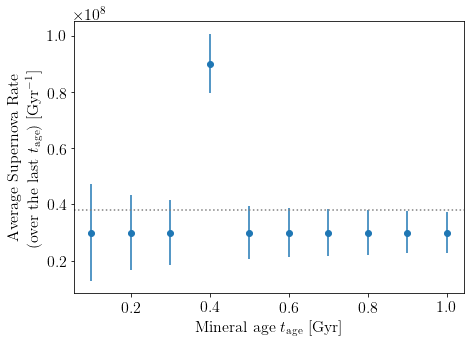

5.587239492653905

In [45]:
R1 = np.ones(10)*R_bench_Gyr
R1[3] = R_bench_Gyr*3
Distinguish_sig(R1, do_plot=True)

In [47]:
t_star_list = np.linspace(0.05, 0.95, 10)
Ntilde_list = np.logspace(6, 9, 200)

def GetNmin(C238=0.01):
    infile = "../data/results/Ntilde_vs_tstar_C238_" + str(C238) + ".txt"
    if (os.path.isfile(infile)):
        tstar1, Ntilde1 = np.loadtxt(infile, unpack=True)
    else:
        
        distinguish_list = np.zeros_like(t_star_list)

        for i,t in enumerate(t_star_list):
            print(i)
            
            dist_sig = 0.0
            for N in Ntilde_list:
                R_list = CalcR(R_0=R_bench_Gyr, N_tilde=N, t_star=t, t_age=np.linspace(0.1, 1, 10))
                #print(R_list)
                dist_sig = Distinguish_sig(R_list, C238=C238, do_plot=False)
                if (dist_sig > 3.0):
                    distinguish_list[i] = N
                    break

        tstar1 = np.append(t_star_list, 1.05)
        tstar1 = np.append( -0.05,tstar1)
        Ntilde1 = np.append(distinguish_list, 0.0)
        Ntilde1 = np.append(0.0, Ntilde1)
        np.savetxt("../data/results/Ntilde_vs_tstar_C238_" + str(C238) + ".txt", list(zip(tstar1, Ntilde1)))
    
    return tstar1, Ntilde1
        

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


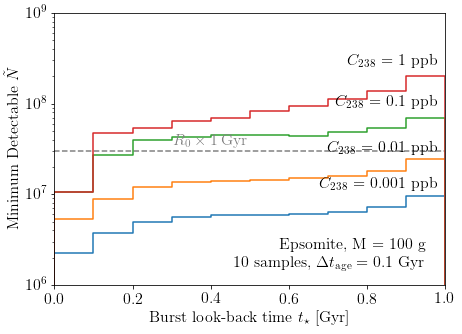

In [48]:
plt.figure(figsize=(7,5))

#plt.axhline(2.3e-2, linestyle='--', color='grey')
#plt.axhline(3.2e-2, linestyle='--', color='grey')

#plt.plot(tstar1, Ntilde1, 'o')
for C in [0.001, 0.01, 0.1, 1.0]:
#for C in [ 0.01]:
    ts, Nt = GetNmin(C238=C)
    plt.step(ts, Nt, where='mid')#,label=r"$C_{238}$ = " + str(C) + " ppb")

plt.xlabel(r'Burst look-back time $t_\star$ [Gyr]')
plt.ylabel(r'Minimum Detectable $\tilde{N}$')
#plt.legend(loc='upper left')

plt.text(0.98, 2.3e8, "$C_{238}$ = 1 ppb", va='bottom',ha='right')
plt.text(0.98, 8.0e7, "$C_{238}$ = 0.1 ppb", va='bottom',ha='right')
plt.text(0.98, 2.5e7, "$C_{238}$ = 0.01 ppb", va='bottom',ha='right')
plt.text(0.98, 1.0e7, "$C_{238}$ = 0.001 ppb", va='bottom',ha='right')

#plt.text(0.05, 0.95, "Epsomite, M = 100 g, $t_\mathrm{age} = 1$ Gyr", 
#            va='top',ha='left', transform=plt.gca().transAxes)
#$C_{238} = 0.01$ ppb
plt.text(0.95, 0.05, "Epsomite, M = 100 g\n10 samples, $\\Delta t_\\mathrm{age} = 0.1$ Gyr", 
            va='bottom',ha='right', transform=plt.gca().transAxes)

plt.text(0.4, 3.1e7, r"$R_0 \times 1\,\mathrm{Gyr}$" ,  va='bottom',ha='center', color='grey')
plt.axhline(3e7, color='grey', linestyle='--', zorder=0)

#------------

plt.gca().set_yscale('log')

plt.xlim(0,1)
plt.ylim(1e6, 1e9)
#plt.ylim(5e-3, 1)
#plt.gca().tick_params(axis='x', which='major', pad=8)

# plt.savefig('../plots/N_min_vs_t_star.pdf', bbox_inches='tight')
plt.show()

### Translating the starburst parameters

$$ 
\begin{align}
    \Phi_\mathrm{gal} &\propto \tilde{N} \langle D^{-2} \rangle \\
    \Phi_\star &\propto N_\star D_\star^{-2}
\end{align}
$$

Starburst durations could be short (~5-10 Myrs) or long (100s of Myr). 

For short ones, see https://arxiv.org/abs/astro-ph/0003334 or https://arxiv.org/abs/astro-ph/0311485.

But see also https://arxiv.org/abs/1009.2940 for a discussion of possibly longer star-bursts.

In [50]:
def AverageFluxDistance():
    F = calc_f()
    
    dist_weight = lambda R: F(R)/4/np.pi/((R)**2.) 
    assert (quad(F, 0, 1e3)[0] - 1)**2 < 1e-3
    return quad(dist_weight, 0., 30)[0]

In [51]:
#This is the average value of 1/R^2 over the entire Galaxy
Flux_Gal = AverageFluxDistance()

100%|██████████| 100000/100000 [00:56<00:00, 1769.38it/s]
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [52]:
print(Flux_Gal)

0.002515914005821105


In [53]:
def calcNbar(N_star, D_star):
    return N_star/(Flux_Gal*4*np.pi*D_star**2)

In [54]:
calcNbar(1, 5.48)

1.0532542645002947

Then we need to worry about how many CC SN should be occuring in a star-burst region.

Following e.g. https://arxiv.org/abs/1006.3899, let's write the initial mass function of stars as:

$$ P(m) = C m^\gamma$$

We could take the minimum CC SN mass as $M_{CCSN} = 8 \,M_\odot$ and the slope as -2.35 (Saltpeter 1955, see https://arxiv.org/abs/1006.3899). There are obviously more complicated models, but we use this one for simplicity. We also go up to $150 \, M_\odot$ as the largest initial stellar mass.

In fact, we can't normalise this thing, so let's use the Kroupa (2001) IMF (https://arxiv.org/abs/astro-ph/0009005):

In [55]:
@np.vectorize
def IMF_unnormed(m):
    gamma = 1.3
    if (m < 0.08):
        gamma = 0.3
    elif (m > 0.5):
        gamma = 2.3
    return m**-gamma

IMF_norm = quad(IMF_unnormed, 0, 150.)[0]
print(IMF_norm)

def IMF(m):
    return IMF_unnormed(m)/IMF_norm

print(quad(IMF, 0, 150.)[0])

5.144279118166372
1.0000000000000007


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [56]:
# Average stellar mass
M_bar = quad(lambda x: IMF(x)*x, 0, 150.)[0]
print(M_bar)

0.7787329894962589


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [57]:
#Fraction of stars ending in CC SN
frac_CCSN = quad(lambda x: IMF(x), 8., 150.)[0]
print(frac_CCSN)

0.009794755875599224


Now for the star formation rate (see e.g. https://arxiv.org/abs/0906.3688)

Typical values in the range $0.1 \,M_\odot\,\mathrm{yr}^{-1}$ - $1000 \,M_\odot\,\mathrm{yr}^{-1}$ - we then have to divide by the average mass of a star $\bar{M}$ to obtain the rate of star formation (in stars per year). We then finally multiply by the fraction of stars which go CC SN to get the rate of CC SN.

In [58]:
import matplotlib.colors as colors

['$10^{6}$', '', '', '', '', '$10^{7}$', '', '', '', '', '$10^{8}$']


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


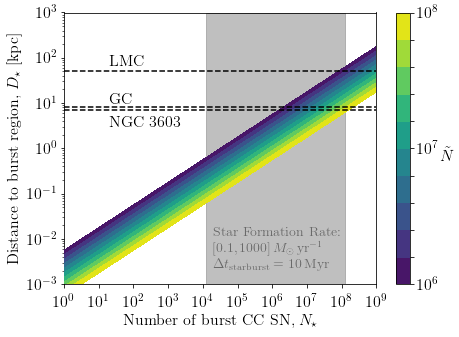

In [59]:
N_D = 200
N_N = 200

D_star_list = np.geomspace(1e-3, 1000, N_N)
N_star_list = np.geomspace(1e0, 1e9, N_D)

N_grid, D_grid = np.meshgrid(N_star_list, D_star_list, indexing='ij')

N_tilde_grid = calcNbar(N_grid, D_grid)

plt.figure(figsize=(7,5))

plt.axhline(50, linestyle='--', color='black', zorder=5)
plt.text(20, 55 , "LMC", color='black', ha='left', va='bottom' )

plt.axhline(6.9, linestyle='--', color='black', zorder=5)
plt.text(20, 5.5, "NGC 3603", color='black', ha='left', va='top' )

plt.axhline(8.12, linestyle='--', color='black', zorder=5)
plt.text(20, 8.7, "GC", color='black', ha='left', va='bottom' )

#Ten megayears
plt.axvspan((0.1/M_bar)*frac_CCSN*10e6, (1e3/M_bar)*frac_CCSN*10e6, color='grey', alpha=0.5, zorder=0)
plt.text(2.0e4, 0.02, 
         "Star Formation Rate:\n$[0.1, 1000]\\,M_\\odot \\,\\mathrm{yr}^{-1}$\n$\\Delta t_\\mathrm{starburst} = 10\\,\\mathrm{Myr}$",
         color='dimgray', ha='left', va='top' ,fontsize=14)

Nlevels = 11
plt.contourf(N_grid, D_grid, N_tilde_grid, levels=np.geomspace(1e6, 1e8, Nlevels), 
             zorder=4,cmap=plt.get_cmap('viridis'),norm=colors.LogNorm())

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

cb = plt.colorbar()
cb.set_label(r'$\tilde{N}$', rotation=0.5, labelpad = 8)

cb.set_ticks(np.geomspace(1e6, 1e8, Nlevels))

cbticklabs = [r'' for i in range(int(Nlevels))]
cbticklabs[0] = r"$10^{6}$"
cbticklabs[5] = r"$10^{7}$"
cbticklabs[-1] = r"$10^{8}$"
print(cbticklabs)
cb.set_ticklabels(cbticklabs)

plt.xlabel(r"Number of burst CC SN, $N_\star$")
plt.ylabel(r"Distance to burst region, $D_\star$ [kpc]")

plt.xlim(1e0, 1e9)
plt.xticks([1e0,1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
plt.gca().tick_params(axis='x', which='major', pad=8)

# plt.savefig("../plots/Burst_parameters.pdf", bbox_inches='tight')

plt.show()

#### Plotting the star-burst in terms of a benchmark

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


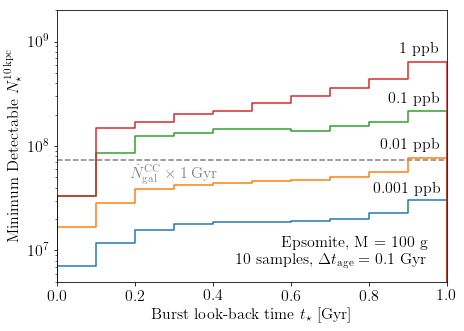

In [60]:
plt.figure(figsize=(7,5))

#plt.axhline(2.3e-2, linestyle='--', color='grey')
#plt.axhline(3.2e-2, linestyle='--', color='grey')

#plt.plot(tstar1, Ntilde1, 'o')
for C in [0.001, 0.01, 0.1, 1.0]:
#for C in [ 0.01]:
    ts, Nt = GetNmin(C238=C)
    Nt *= 4*np.pi*(10)**2*Flux_Gal
    plt.step(ts, Nt, where='mid')#,label=r"$C_{238}$ = " + str(C) + " ppb")

plt.xlabel(r'Burst look-back time $t_\star$ [Gyr]')
plt.ylabel(r'Minimum Detectable $N_\star^{10\,\mathrm{kpc}}$')
#plt.legend(loc='upper left')

A = 0.95*4*np.pi*(10)**2*Flux_Gal
#$C_{238}$ = 
plt.text(0.98, A*2.4e8, "1 ppb", va='bottom',ha='right')
plt.text(0.98, A*7.9e7, "0.1 ppb", va='bottom',ha='right')
plt.text(0.98, A*2.9e7, "0.01 ppb", va='bottom',ha='right',bbox=dict(facecolor='white', edgecolor='None'))
plt.text(0.98, A*1.1e7, "0.001 ppb", va='bottom',ha='right')

#plt.text(0.05, 0.95, "Epsomite, M = 100 g, $t_\mathrm{age} = 1$ Gyr", 
#            va='top',ha='left', transform=plt.gca().transAxes)
#$C_{238} = 0.01$ ppb
plt.text(0.95, 0.05, "Epsomite, M = 100 g\n10 samples, $\\Delta t_\\mathrm{age} = 0.1$ Gyr", 
            va='bottom',ha='right', transform=plt.gca().transAxes)

plt.text(0.3, 0.6*2.3*3.1e7, r"$\dot{N}_\mathrm{gal}^\mathrm{CC} \times 1\,\mathrm{Gyr}$" ,  va='bottom',ha='center', color='grey')
plt.axhline(2.3e7*4*np.pi*(10)**2*Flux_Gal, color='grey', linestyle='--', zorder=0)

#------------

plt.gca().set_yscale('log')

plt.xlim(0,1)
plt.ylim(5e6, 2e9)
#plt.ylim(5e-3, 1)
#plt.gca().tick_params(axis='x', which='major', pad=8)

# plt.savefig('../plots/N10kpc_vs_t_star.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


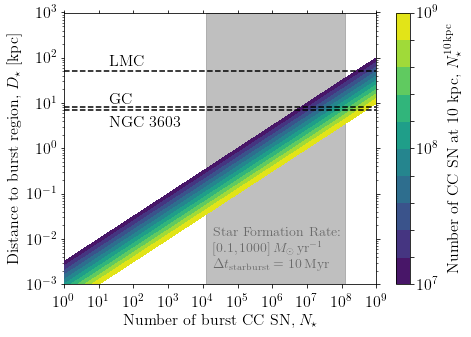

In [61]:
N_D = 200
N_N = 200

D_star_list = np.geomspace(1e-3, 1000, N_N)
N_star_list = np.geomspace(1e0, 1e9, N_D)

N_grid, D_grid = np.meshgrid(N_star_list, D_star_list, indexing='ij')

N_tilde_grid = calcNbar(N_grid, D_grid)*4*np.pi*(10)**2*Flux_Gal

plt.figure(figsize=(7,5))

plt.axhline(50, linestyle='--', color='black', zorder=5)
plt.text(20, 55 , "LMC", color='black', ha='left', va='bottom' )

plt.axhline(6.9, linestyle='--', color='black', zorder=5)
plt.text(20, 5.5, "NGC 3603", color='black', ha='left', va='top' )

plt.axhline(8.12, linestyle='--', color='black', zorder=5)
plt.text(20, 8.7, "GC", color='black', ha='left', va='bottom' )

#Ten megayears
plt.axvspan((0.1/M_bar)*frac_CCSN*10e6, (1e3/M_bar)*frac_CCSN*10e6, color='grey', alpha=0.5, zorder=0)
plt.text(2.0e4, 0.02, 
         "Star Formation Rate:\n$[0.1, 1000]\\,M_\\odot \\,\\mathrm{yr}^{-1}$\n$\\Delta t_\\mathrm{starburst} = 10\\,\\mathrm{Myr}$",
         color='dimgray', ha='left', va='top' ,fontsize=14)

Nlevels = 11
plt.contourf(N_grid, D_grid, N_tilde_grid, levels=np.geomspace(1e7, 1e9, Nlevels), 
             zorder=4,cmap=plt.get_cmap('viridis'),norm=colors.LogNorm())

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

cb = plt.colorbar()
cb.set_label(r'Number of CC SN at 10 kpc, $N_\star^{10\,\mathrm{kpc}}$',  labelpad = 8)#,rotation=0.5)

cb.set_ticks(np.geomspace(1e7, 1e9, Nlevels))

cbticklabs = [r'' for i in range(int(Nlevels))]
cbticklabs[0] = r"$10^{7}$"
cbticklabs[5] = r"$10^{8}$"
cbticklabs[-1] = r"$10^{9}$"
#print(cbticklabs)
cb.set_ticklabels(cbticklabs)

plt.xlabel(r"Number of burst CC SN, $N_\star$")
plt.ylabel(r"Distance to burst region, $D_\star$ [kpc]")

plt.xlim(1e0, 1e9)
plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
plt.gca().tick_params(axis='x', which='major', pad=8)

plt.tick_params(right=True,top=True)
plt.tick_params(which='minor',top=True,right=True)

# plt.savefig("../plots/Burst_parameters_N10kpc.pdf", bbox_inches='tight')

plt.show()

#### Time-evolution Comparison

https://arxiv.org/pdf/1901.07564.pdf

Gaussian component: $\mu = 2.57 \,\text {Gyr}$ and $\sigma = 1.25 \, \mathrm { Gyr }$

In [62]:
def SFR_Mor(t):
    
    B = 0.722
    tau = 10/(np.log(11.4/B))
    expo =  B*np.exp(t/tau)
    
    sig = 1.25
    mu = 2.57
    A = (8.9 - B*np.exp(mu/tau))
    Gauss = A*np.exp(-0.5*(t - mu)**2/sig**2)
    
    return Gauss + expo

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


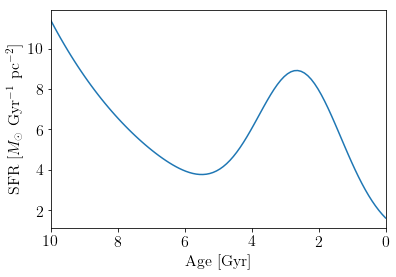

In [63]:
tlist = np.linspace(0, 10, 100)

plt.figure()

plt.plot(tlist, SFR_Mor(tlist))

plt.xlim(10, 0) 

plt.xlabel(r"Age [Gyr]")

plt.ylabel(r"SFR [$M_\odot$ Gyr$^{-1}$ pc$^{-2}$]")

plt.show()


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


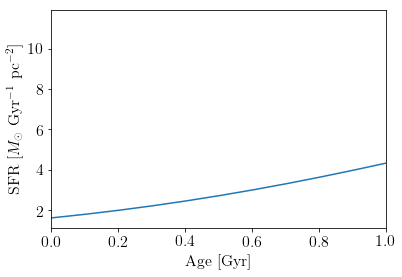

In [64]:
tlist = np.linspace(0, 10, 100)

plt.figure()

plt.plot(tlist, SFR_Mor(tlist))

plt.xlim(0, 1) 

plt.xlabel(r"Age [Gyr]")

plt.ylabel(r"SFR [$M_\odot$ Gyr$^{-1}$ pc$^{-2}$]")

plt.show()

**Next steps:**

 - Cosmological SFR with z
 - Plot average supernova rate measured in each rock...
 - Work out how to fit average SN rate with constant

#### Need to calculate the best fitting constant rate
 
- The points we are fitting are med, we will fit a Gaussian 
$$ min(\frac{R - R_{obs}}{\sigma^2})$$
where $R_{obs}$ is the med list i.e. we are pretending the observation is that of an increasing rate and sigma is the error on the observation

Can this upward trend be fitted well with a constant value?

Do the error bars overlap? First fit the best fitting constant rate?

The final data point in the Mor+ constraints *is* the best estimate of the constant rate!

Correct likelihood is: P(N1 in short exposure | R0) x P(N2 in long exposure | R0, N1 in short exposure)

30000000.0
[31611858.80509397 33346633.55161702 35208622.58127359 37201145.93772465
 39326357.31766345 41585059.72776814 43976530.99337796 46498365.69847445
 49146340.3400015  51914308.41356225]


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


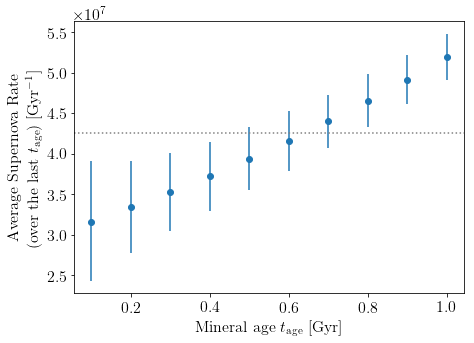

4.977660702355584


In [65]:
t_list = np.linspace(0.1, 1, 10)

R_list_Mor = np.array([quad(SFR_Mor, 0, t_list[i])[0]/(t_list[i]) for i in range(10)])
R_list_Mor *= R_bench_Gyr/SFR_Mor(0)
print(R_bench_Gyr)
print(R_list_Mor)
print(Distinguish_sig(R_list_Mor, C238=0.001, do_plot=True,filename="RateRecon_Mor_C=0.001ppb.pdf"))


In [66]:
H0 = 67.4 #(km/s)/Mpc
H0_peryr = H0*(3.24e-20)*(60*60*24*365) #1/yr

rho_crit = 4.87235e-6/37.96 #M_sun pc^-3
#print(rho_crit*1e18)
Omega_L = 0.689
Omega_m = 0.315
Omega_r = 9.24e-5

def Hubble(z):
    return H0*np.sqrt(Omega_L + Omega_m*(1+z)**3 + Omega_r*(1+z)**4)

def Hubble_peryr(z):
    return Hubble(z)*H0_peryr/H0

def t_univ(z):    
    integ = lambda x: 1.0/((1+x)*Hubble_peryr(x))
    return quad(integ, z, np.inf)[0]

zlist = np.linspace(0, 5, 201)
tuniv_list = np.array([t_univ(z) for z in zlist])
#print(tuniv_list)
z_of_t = interpolate.interp1d(tuniv_list[0] - tuniv_list, zlist)
print(z_of_t(13.7e9-5.9e9))

0.9646678018460402


In [67]:
#t in Gyr
def SFR_Cosmo(t):
    z = z_of_t(t*1e9)
    return 0.015*(1+z)**2.7/(1 + ((1+z)/2.9)**5.6)

30000000.0
[30284220.3833944  30570642.94171859 30859273.39928599 31150656.07505179
 31447791.56947312 31749570.85685509 32055024.61559876 32365204.71941608
 32680660.58319353 33000592.54705195]


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


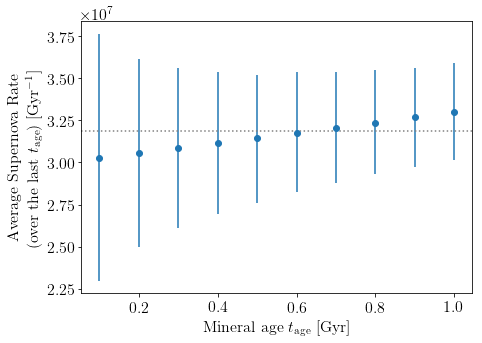

0.6542899613317271


In [68]:
t_list = np.linspace(0.1, 1, 10)

R_list_Cosmo = np.array([quad(SFR_Cosmo, 0, t_list[i])[0]/(t_list[i]) for i in range(10)])
R_list_Cosmo *= R_bench_Gyr/SFR_Cosmo(0)
print(R_bench_Gyr)
print(R_list_Cosmo)
print(Distinguish_sig(R_list_Cosmo, C238=0.001, do_plot=True, filename="RateRecon_Cosmo_C=0.001ppb.pdf"))

In [ ]:
Clist = np.array([0.001, 0.01, 0.1, 1.0])
siglist_Mor = np.array([Distinguish_sig(R_list_Mor, C238=C, do_plot=False) for C in Clist])
siglist_Cosmo = np.array([Distinguish_sig(R_list_Cosmo, C238=C, do_plot=False) for C in Clist])

In [ ]:
plt.figure(figsize=(7,5))

plt.semilogx(Clist, siglist_Mor, 's', label='Mor et al. SFR (1901.07564)')
plt.semilogx(Clist, siglist_Cosmo, 'o', label='Cosmological SFR (1403.0007)')


plt.legend(fontsize=15.0)
plt.xlabel(r'Uranium-238 Concentration [ppb]')
plt.ylabel(r'Discrimination Significance [$\sigma$]')

plt.gca().tick_params(axis='x', which='major', pad=8)
# plt.savefig("../plots/TimeDependent.pdf", bbox_inches='tight')
plt.show()
